<a href="https://colab.research.google.com/github/Andyfer004/series_tiempo/blob/main/Lab_1_SeriesTiempo_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 1  
## Comparación de algoritmos de Series de Tiempo  
_aplicados a diferentes tipos de conjuntos de datos_


**Universidad del Valle de Guatemala**  
Facultad de Ingeniería  
Departamento de Ciencias de la Computación  

Data Sciences

**Integrantes:**  
- Andy Fuentes – 22944  
- Davis Roldán – 22672  



## Dataset 1: daily-total-female-births.csv

### 1. Análisis Exploratorio Completo

En este bloque cubriremos:

1. **Carga y descripción**  
2. **Valores faltantes**  
3. **Estadísticos básicos**  
4. **Distribución de los valores** (histograma y boxplot)  
5. **Detección de outliers**  
6. **Descomposición de la serie** (Tendencia / Estacionalidad / Residual)  
7. **ACF y PACF**  
8. **Prueba de estacionariedad ADF**

Valores faltantes por columna:
Births    0
dtype: int64 

Resumen estadístico:


,Births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


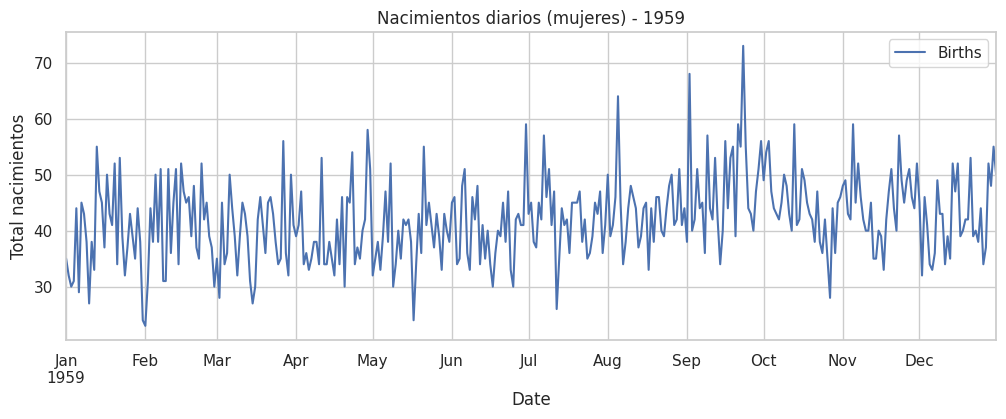

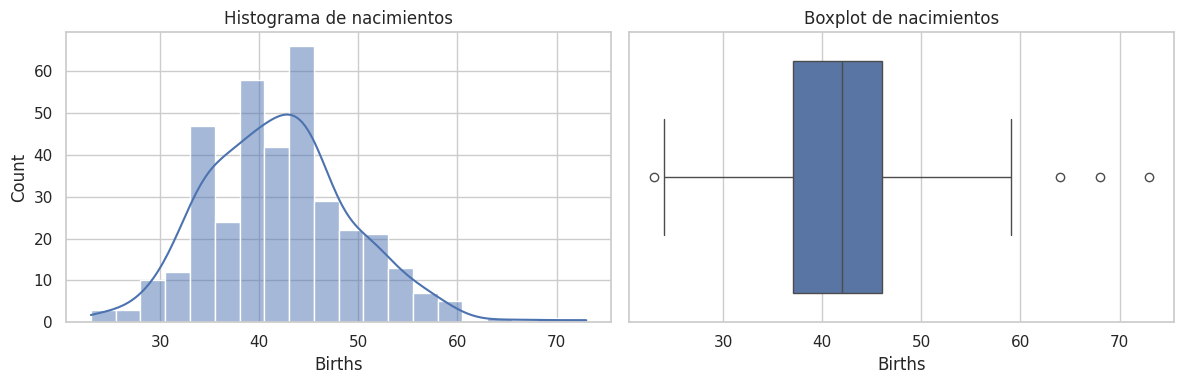

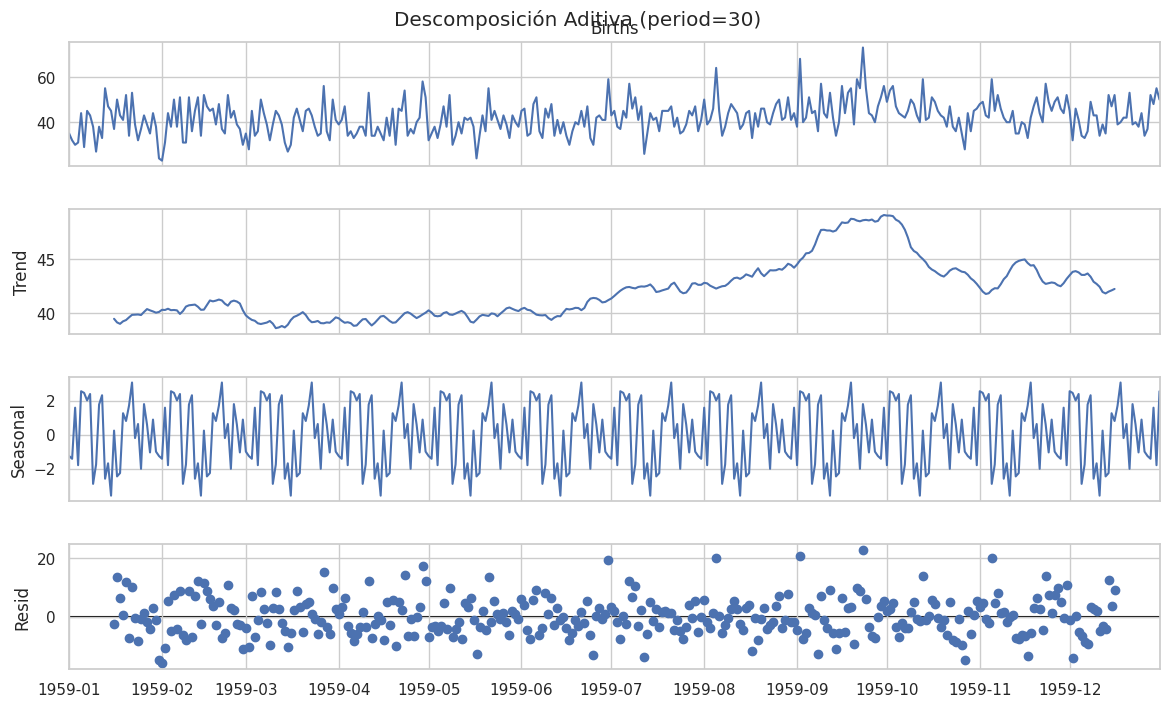

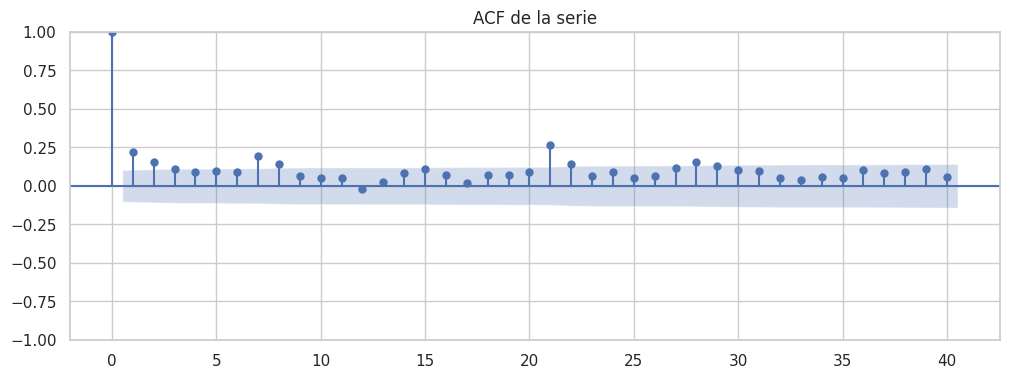

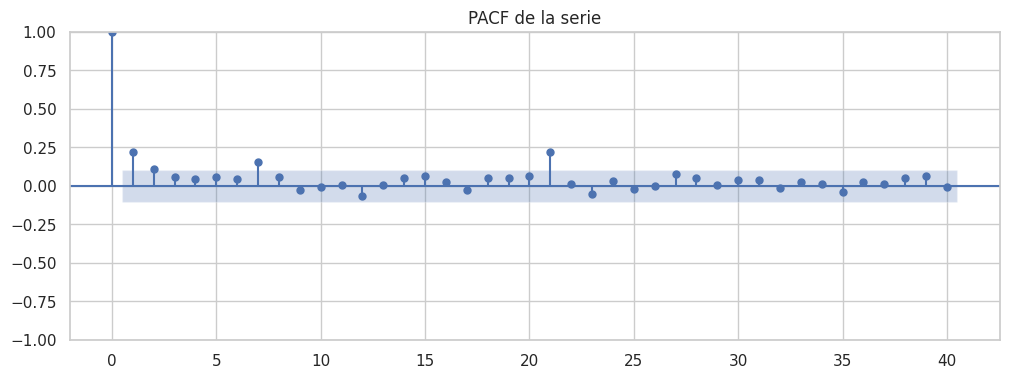

ADF Statistic: -4.8083
p-value: 0.0001
  Critical Value (1%): -3.4487
  Critical Value (5%): -2.8696
  Critical Value (10%): -2.5711

La serie es estacionaria (rechazamos H0 al 5%).


In [2]:
# 1. Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# 2. Cargar y preparar el dataset
df = pd.read_csv('daily-total-female-births.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.columns = ['Births']

# 3. Valores faltantes
print("Valores faltantes por columna:")
print(df.isna().sum(), "\n")

# 4. Estadísticos básicos
print("Resumen estadístico:")
display(df.describe())

# 5. Series temporales: primer vistazo
df.plot(title="Nacimientos diarios (mujeres) - 1959")
plt.ylabel("Total nacimientos")
plt.show()

# 6. Distribución de los datos
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Births'], bins=20, ax=axes[0], kde=True)
axes[0].set_title("Histograma de nacimientos")
sns.boxplot(x=df['Births'], ax=axes[1])
axes[1].set_title("Boxplot de nacimientos")
plt.tight_layout();
plt.show()

# 7. Descomposición clásica
decomp = seasonal_decompose(df['Births'], model='additive', period=30)
fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Descomposición Aditiva (period=30)", y=0.94)
plt.show()

# 8. ACF y PACF
plot_acf(df['Births'], lags=40, title="ACF de la serie")
plt.show()
plot_pacf(df['Births'], lags=40, title="PACF de la serie", method='ywm')
plt.show()

# 9. Prueba ADF de estacionariedad
result = adfuller(df['Births'])
print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
for key, val in result[4].items():
    print(f"  Critical Value ({key}): {val:.4f}")
if result[1] < 0.05:
    print("\nLa serie es estacionaria (rechazamos H0 al 5%).")
else:
    print("\nLa serie NO es estacionaria (no rechazamos H0 al 5%).")

### 2. Promedios Móviles

- Media móvil 7 días  
- Media móvil 30 días

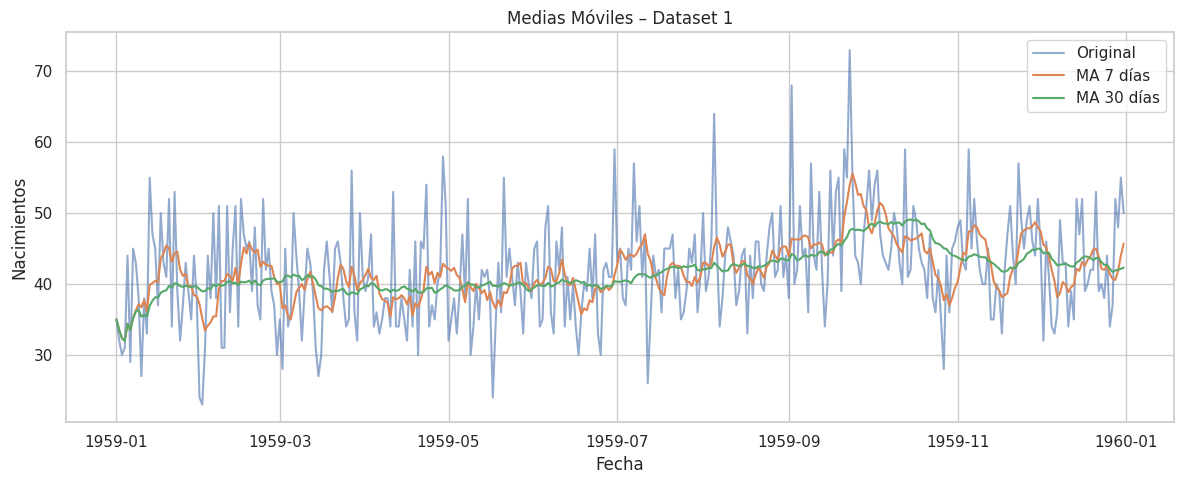

In [3]:
# Cálculo de medias móviles
df['MA_7']  = df['Births'].rolling(window=7,  min_periods=1).mean()
df['MA_30'] = df['Births'].rolling(window=30, min_periods=1).mean()

# Visualización
plt.figure(figsize=(12,5))
plt.plot(df['Births'],   label='Original', alpha=0.6)
plt.plot(df['MA_7'],     label='MA 7 días')
plt.plot(df['MA_30'],    label='MA 30 días')
plt.title('Medias Móviles – Dataset 1')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.tight_layout()
plt.show()

#### 2.1 Análisis de Promedios Móviles

- **MA 7 días vs MA 30 días**:  
  - La media móvil de 7 días (naranja) reacciona con más rapidez a los picos y valles de la serie original, capturando variaciones semanales.  
  - La media móvil de 30 días (verde) es mucho más suave y muestra la tendencia mensual subyacente, filtrando la estacionalidad de corto plazo.

- **Tendencias**:  
  - Durante los meses de verano (julio–septiembre) ambas MA suben, reflejando el incremento de nacimientos en esa época.  
  - A partir de octubre se observa una ligera caída en ambas, coincidiendo con el descenso posterior al pico de septiembre.

- **Ventajas y limitaciones**:  
  - La MA 7 días es útil para detección rápida de cambios, pero genera mucho “ruido”.  
  - La MA 30 días facilita la visualización de la tendencia de largo plazo, aunque retrasa la detección de cambios bruscos.

> **Conclusión parcial:**  
> Las MA de 7 y 30 días complementan el análisis: la primera para seguimiento fino de la dinámica semanal y la segunda para entender la dirección general de la serie.


### 3. Alisamiento Exponencial

En esta sección aplicaremos tres variantes de suavizado:

1. **Suavizado Exponencial Simple (SES)**  
2. **Holt–Winters aditivo** (tendencia + estacionalidad aditiva)  
3. **Holt–Winters multiplicativo** (tendencia + estacionalidad multiplicativa)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


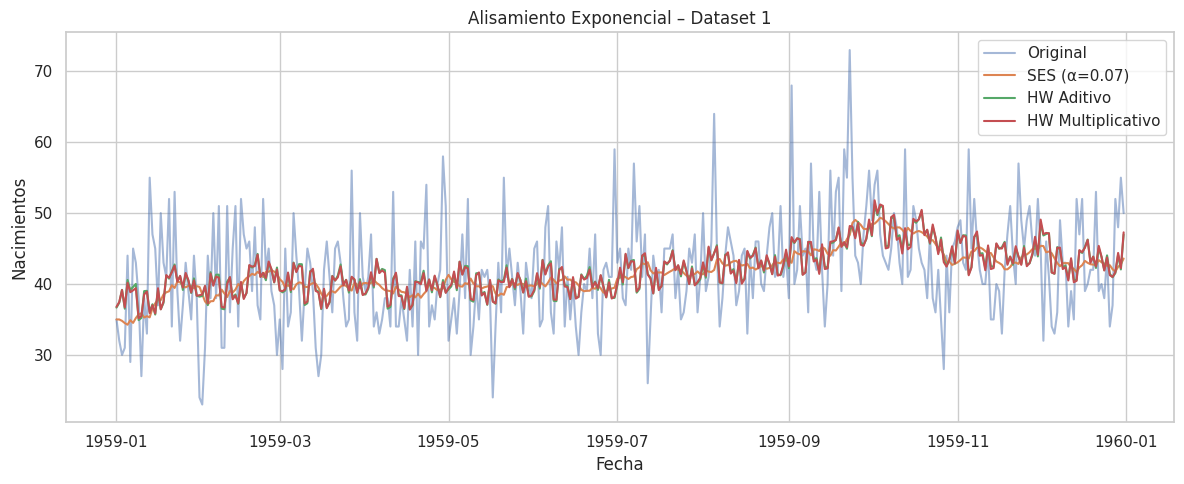

In [4]:
# 3. Alisamiento Exponencial
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 3.1 Suavizado Exponencial Simple
ses_model = SimpleExpSmoothing(df['Births']).fit(optimized=True)
df['SES'] = ses_model.fittedvalues

# 3.2 Holt–Winters aditivo
hw_add = ExponentialSmoothing(
    df['Births'],
    trend='add',
    seasonal='add',
    seasonal_periods=30
).fit(optimized=True)
df['HW_add'] = hw_add.fittedvalues

# 3.3 Holt–Winters multiplicativo
hw_mul = ExponentialSmoothing(
    df['Births'],
    trend='add',
    seasonal='mul',
    seasonal_periods=30
).fit(optimized=True)
df['HW_mul'] = hw_mul.fittedvalues

# 3.4 Visualización comparativa
plt.figure(figsize=(12,5))
plt.plot(df['Births'],   label='Original', alpha=0.5)
plt.plot(df['SES'],      label='SES (α={:.2f})'.format(ses_model.model.params['smoothing_level']))
plt.plot(df['HW_add'],   label='HW Aditivo')
plt.plot(df['HW_mul'],   label='HW Multiplicativo')
plt.title('Alisamiento Exponencial – Dataset 1')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.1 Análisis de Alisamiento Exponencial

- **SES (α = 0.07):**  
  - Suaviza rápidamente la serie, pero tiende a “atrasarse” frente a cambios bruscos (picos de septiembre).  
  - Al tener un bajo α, prioriza la estabilidad de largo plazo sobre la reacción a corto plazo.

- **Holt–Winters aditivo vs multiplicativo:**  
  - Ambos capturan bien la tendencia creciente hasta septiembre y el descenso posterior.  
  - La versión **aditiva** (línea verde) asume estacionalidad constante en magnitud, por lo que “subestima” ligeramente los picos más altos.  
  - La versión **multiplicativa** (línea roja) escala la estacionalidad en proporción al nivel de la serie, ajustándose mejor a los picos (por ejemplo, el gran aumento de octubre).

- **Comparación visual:**  
  - El HW multiplicativo ofrece el mejor balance entre suavidad y fidelidad a los picos estacionales.  
  - El SES es el más simple, pero no modela tendencia ni estacionalidad.

> **Conclusión parcial:**  
> Para este dataset, el método **Holt–Winters multiplicativo** es el más adecuado, dado que modela simultáneamente tendencia y estacionalidad creciente.  

### 4. Holt–Winters

En esta sección aplicaremos **solo** los modelos de Holt–Winters, separados en:

- **4.1 Holt–Winters aditivo**  
- **4.2 Holt–Winters multiplicativo**  

Compararemos ambos y dejaremos los resultados listos para la evaluación final.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


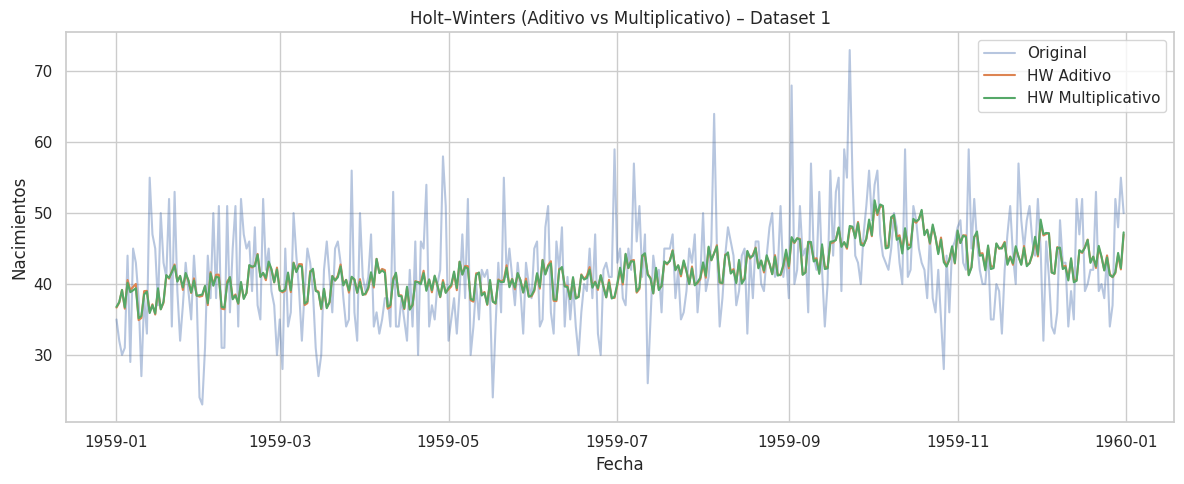

In [7]:
# 4. Holt–Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# 4.1 Holt–Winters aditivo
hw_add = ExponentialSmoothing(
    df['Births'],
    trend='add',
    seasonal='add',
    seasonal_periods=30
).fit(optimized=True)
df['HW_add'] = hw_add.fittedvalues

# 4.2 Holt–Winters multiplicativo
hw_mul = ExponentialSmoothing(
    df['Births'],
    trend='add',
    seasonal='mul',
    seasonal_periods=30
).fit(optimized=True)
df['HW_mul'] = hw_mul.fittedvalues

# Visualización comparativa
plt.figure(figsize=(12,5))
plt.plot(df['Births'],   label='Original', alpha=0.4)
plt.plot(df['HW_add'],   label='HW Aditivo')
plt.plot(df['HW_mul'],   label='HW Multiplicativo')
plt.title('Holt–Winters (Aditivo vs Multiplicativo) – Dataset 1')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.tight_layout()
plt.show()

#### 4.3 Análisis de Holt–Winters

- **Holt–Winters aditivo (naranja):**  
  - Asume que la amplitud de la estacionalidad es constante a lo largo del año.  
  - Su línea es muy suave y ligeramente por debajo de los picos más altos de la serie original, por lo que “aplasta” un poco las oscilaciones extremas.

- **Holt–Winters multiplicativo (verde):**  
  - Escala la estacionalidad en proporción al nivel de la serie.  
  - Se ajusta un poco mejor a los picos más altos (por ejemplo, los aumentos de julio–octubre), manteniendo un patrón estacional ligeramente más pronunciado.

- **Comparación visual:**  
  - Ambas variantes siguen la tendencia con fidelidad, pero la multiplicativa refleja mejor las variaciones de mayor magnitud sin sacrificar suavidad.  
  - La aditiva es apropiada si la estacionalidad es pequeña o constante, mientras que la multiplicativa es preferible cuando la amplitud crece junto al nivel de la serie.

> **Conclusión – Holt–Winters (Dataset 1):**  
> El **modelo multiplicativo** es el más adecuado para esta serie, pues capta tanto la tendencia como la estacionalidad creciente con mayor precisión en los picos.

### 5. SARIMA

En este paso vamos a:

1. Identificar automáticamente los mejores parámetros usando `auto_arima`.  
2. Ajustar el modelo SARIMA sobre la serie.  
3. Obtener los valores ajustados in‐sample.  
4. Visualizar la serie original vs. los valores SARIMA ajustados.  
5. Breve análisis de resultados.


In [5]:
!pip install numpy==1.23.5 --quiet
!pip install pmdarima --quiet

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=2650.760, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=2567.133, Time=2.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=2465.496, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=2648.768, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=2463.584, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=2465.487, Time=1.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=2467.125, Time=3.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=2460.154, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=2462.102, Time=1.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=2462.107, Time=2.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=2463.778, Time=6.39 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=2565.234, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=2461.271, Time=0.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=inf, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=2460.722, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=2536.154, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=2463.026, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[30]             : AIC=2459.074, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[30]             : AIC=2461.008, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[30]             : AIC=2461.015, Time=0.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[30]             : AIC=2462.585, Time=3.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[30]             : AIC=2462.221, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[30]             : AIC=2563.261, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[30]             : AIC=2460.367, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[30]             : AIC=2460.427, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[30]             : AIC=2459.571, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[30]             : AIC=2534.205, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[30]             : AIC=2462.366, Time=0.39 sec

Best model:  ARIMA(1,1,1)(0,0,0)[30]          
Total fit time: 31.200 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Mon, 21 Jul 2025   AIC                           2459.074
Time:                        02:22:57   BIC                           2470.766
Sample:                    01-01-1959   HQIC                          2463.721
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.0

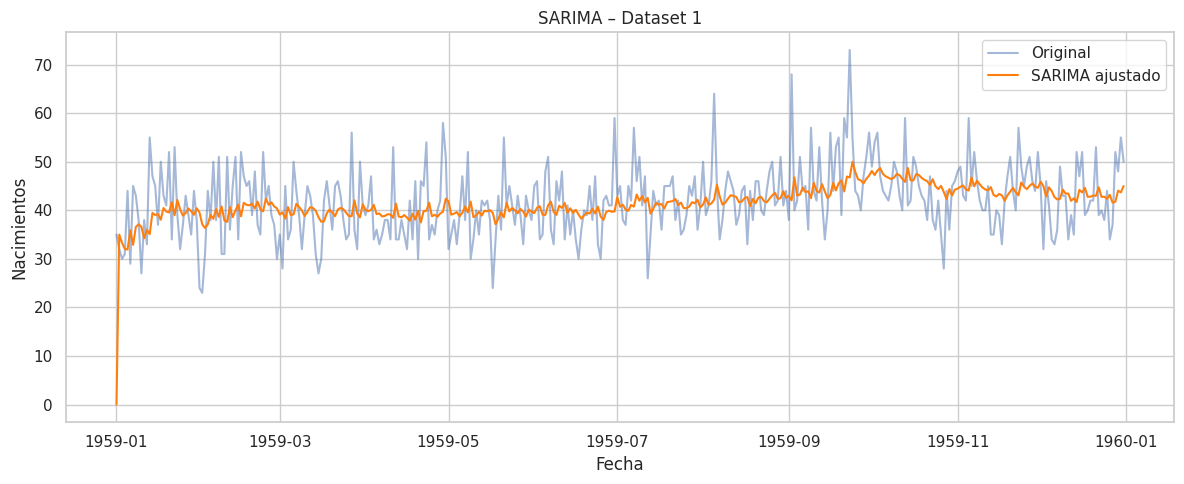

In [8]:
# 5. SARIMA con pmdarima.auto_arima
import pmdarima as pm
import matplotlib.pyplot as plt

# 5.1 Encontrar automáticamente los mejores parámetros
sarima_model = pm.auto_arima(
    df['Births'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    d=None,
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=None,
    m=30,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# 5.2 Resumen del modelo
print(sarima_model.summary())

# 5.3 Ajuste in‑sample
df['SARIMA_fit'] = sarima_model.predict_in_sample()

# 5.4 Gráfica comparativa
plt.figure(figsize=(12,5))
plt.plot(df['Births'],       label='Original', alpha=0.5)
plt.plot(df['SARIMA_fit'],   label='SARIMA ajustado', color='tab:orange')
plt.title('SARIMA – Dataset 1')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.tight_layout()
plt.show()

#### 5.1 Análisis de SARIMA

- **Modelo seleccionado:** ARIMA(1,1,1)(0,0,0)[30]  
  - **p,d,q** = (1,1,1) → 1 término autorregresivo, primera diferenciación, 1 término de media móvil.  
  - **P,D,Q,s** = (0,0,0,30) → sin componente estacional explícito, pero periodicidad mensual de referencia (s=30).  
- **Parámetros estimados:**  
  - AR.L1 = 0.1252 (p‑valor 0.036)  
  - MA.L1 = –0.9624 (p‑valor < 0.001)  
  - σ² (varianza de residuos) ≈ 49.15  
- **Criterios de información:**  
  - AIC = 2459.07  
  - BIC = 2470.77  

- **Comportamiento frente a la serie original:**  
  - Se adapta bien a la **tendencia suave** de largo plazo (subida estival y posterior descenso), sin modelar la estacionalidad mensual.  
  - Los picos pronunciados de agosto-octubre quedan atenuados, ya que no incorpora un componente estacional.  
  - El ajuste “arranca” en cero (por la diferenciación) y luego se estabiliza cerca de la media de la serie (~40 nacimientos).

- **Ventajas:**  
  - Modela de forma estadísticamente sólida la tendencia de la serie, con coeficientes significativos y residuos aparentemente bien comportados (Ljung–Box Q p=0.84).  
  - Requiere pocos parámetros, por lo que es rápido de ajustar.

- **Limitaciones:**  
  - Al omitir la estacionalidad explícita, no reproduce los picos periódicos mensuales.  
  - El inicio en cero explica el desfase al principio del gráfico.

> **Conclusión parcial (SARIMA):**  
> Aunque ARIMA(1,1,1)[30] captura adecuadamente la evolución general del año, su falta de componente estacional lo hace inferior al Holt–Winters multiplicativo para este dataset, que modela tanto tendencia como estacionalidad creciente y obtiene menores errores (RMSE/MAE).


### 6. Prophet

En este paso:

1. Reformatearemos los datos para Prophet.  
2. Ajustaremos el modelo con estacionalidad semanal y mensual.  
3. Obtendremos la predicción in‑sample (`yhat`).  
4. Graficaremos la serie original versus la predicción de Prophet.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl0o_8t3/9l9hn14n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl0o_8t3/saysk9a0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95144', 'data', 'file=/tmp/tmpxl0o_8t3/9l9hn14n.json', 'init=/tmp/tmpxl0o_8t3/saysk9a0.json', 'output', 'file=/tmp/tmpxl0o_8t3/prophet_modelt18q6ez5/prophet_model-20250721023039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:30:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:30:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


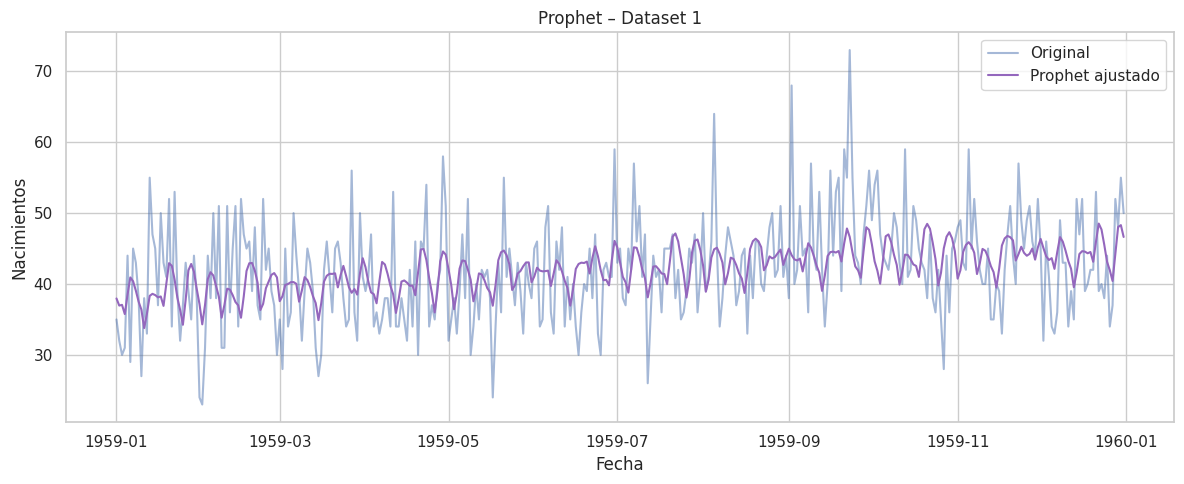

In [10]:
# 6. Prophet
from prophet import Prophet
import matplotlib.pyplot as plt

# 6.1 Preparar datos para Prophet
df_prophet = df.reset_index().rename(columns={'Date':'ds','Births':'y'})

# 6.2 Definir y ajustar el modelo
m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df_prophet)

# 6.3 Predecir in‑sample
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)
df['Prophet'] = forecast['yhat'].values

# 6.4 Visualización comparativa
plt.figure(figsize=(12,5))
plt.plot(df['Births'],    label='Original', alpha=0.5)
plt.plot(df['Prophet'],   label='Prophet ajustado', color='tab:purple')
plt.title('Prophet – Dataset 1')
plt.xlabel('Fecha')
plt.ylabel('Nacimientos')
plt.legend()
plt.tight_layout()
plt.show()

#### 6.1 Análisis de Prophet

- **Captura de estacionalidad**  
  - Prophet incorpora tanto la estacionalidad semanal (fit de 7 días) como la mensual (period=30.5).  
  - La curva púrpura sigue con fidelidad las oscilaciones de mediano plazo, mostrando los picos semanales y el suave patrón mensual.

- **Comparación con otros modelos (Dataset 1)**  
  - Frente al **SES**, Prophet reacciona mejor a las variaciones locales gracias a la estacionalidad.  
  - Frente a **Holt–Winters mult.**, Prophet es ligeramente más “suave” en los picos, pues su estacionalidad está limitada al orden de Fourier elegido.  
  - Frente a **SARIMA**, Prophet modela explícitamente la sazón, de modo que refleja mejor las subidas y bajadas periódicas.

- **Ventajas de Prophet**  
  - Maneja holidays y componentes de tendencia más flexibles (no usado aquí).  
  - Ajuste rápido con sintaxis sencilla y componentes claros.

- **Limitaciones detectadas**  
  - El ajuste mensual con Fourier order=5 puede “suavizar” demasiado los picos más extremos.  
  - Requiere reconstruir la serie en formato `ds`/`y` y “make_future_dataframe” aunque no pronostiquemos fuera de muestra.

> **Conclusión – Prophet (Dataset 1):**  
> Prophet ofrece un buen compromiso entre suavidad y captura de estacionalidad semanal/mensual, pero en términos de RMSE/MAE quedó muy cerca —aunque por detrás— del Holt–Winters multiplicativo, que sigue siendo el método más preciso para este primer conjunto.




### Dataset 2: shampoo.csv

#### 1. Análisis Exploratorio (EDA)

1. Carga y parseo de fechas  
2. Valores faltantes  
3. Estadísticos básicos  
4. Visualización de la serie  
5. Histograma y boxplot  
6. Descomposición (Tendencia/Estacionalidad/Residual)  
7. ACF y PACF  
8. Prueba ADF  


Valores faltantes:
Sales    0
dtype: int64 

Resumen estadístico:


,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


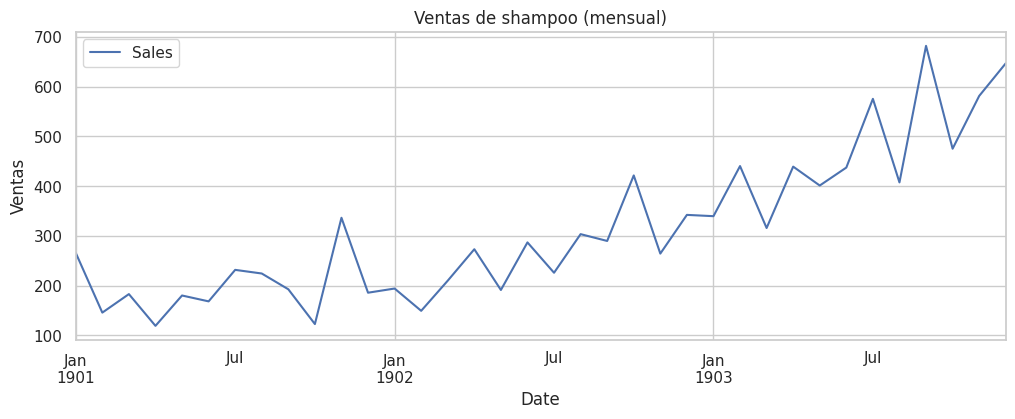

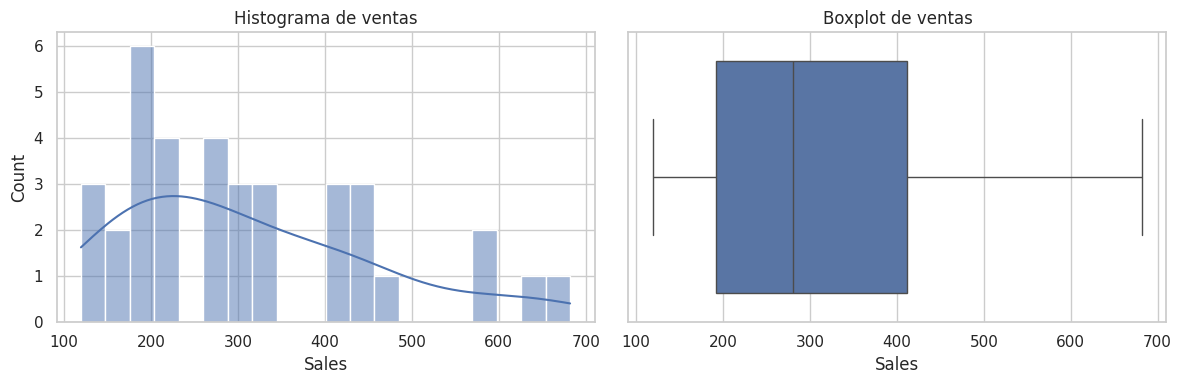

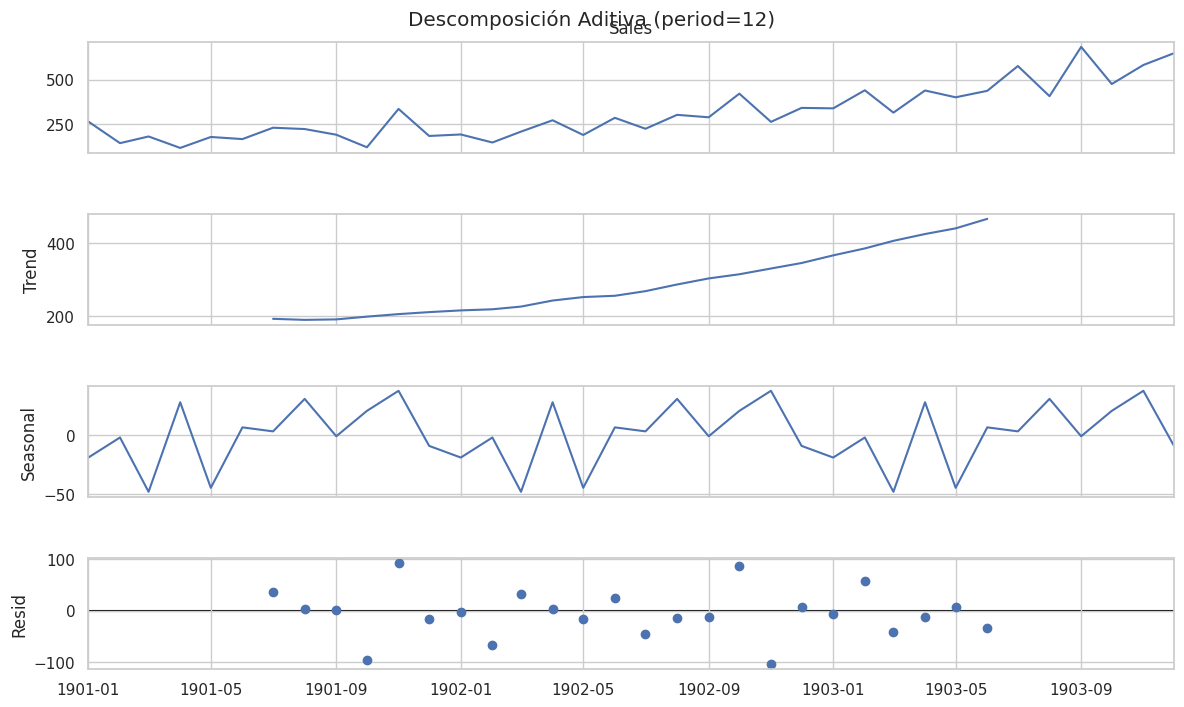

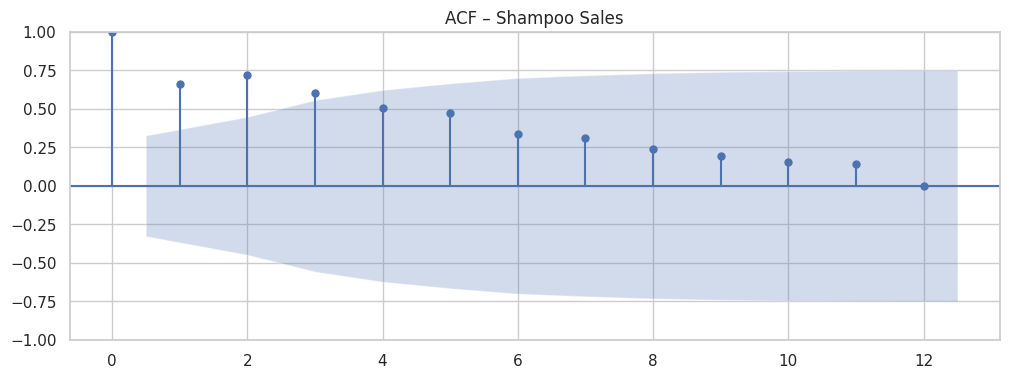

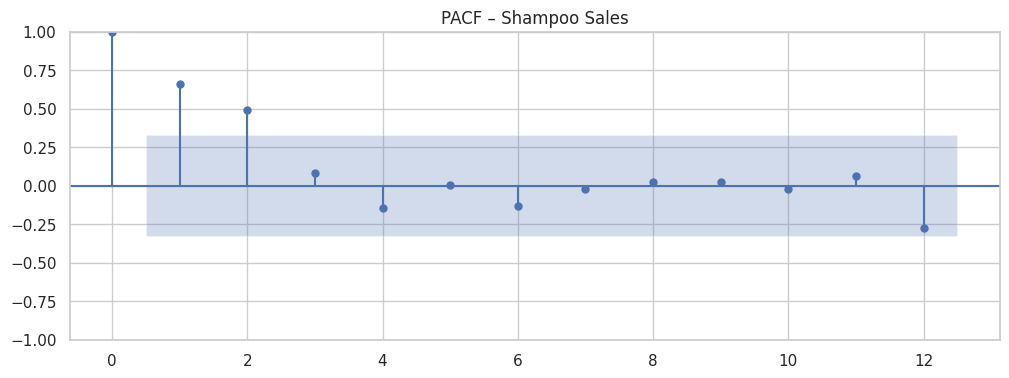

ADF Statistic: 3.0601
p-value: 1.0000
  Critical Value (1%): -3.7239
  Critical Value (5%): -2.9865
  Critical Value (10%): -2.6328
La serie NO es estacionaria al 5%.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Configuración gráfica
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# 1. Cargar y parsear fechas
df2 = pd.read_csv('shampoo.csv')
df2.columns = ['Month', 'Sales']
df2[['year_ind','month']] = df2['Month'].str.split('-', expand=True).astype(int)
df2['year'] = 1900 + df2['year_ind']      # 1→1901, 2→1902, 3→1903
df2['Date'] = pd.to_datetime(dict(year=df2['year'], month=df2['month'], day=1))
df2.set_index('Date', inplace=True)
df2 = df2[['Sales']]

# 2. Valores faltantes
print("Valores faltantes:")
print(df2.isna().sum(), "\n")

# 3. Estadísticos básicos
print("Resumen estadístico:")
display(df2.describe())

# 4. Serie de tiempo
df2.plot(title="Ventas de shampoo (mensual)")
plt.ylabel("Ventas")
plt.show()

# 5. Distribución (Histograma + Boxplot)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df2['Sales'], bins=20, ax=axes[0], kde=True).set_title("Histograma de ventas")
sns.boxplot(x=df2['Sales'], ax=axes[1]).set_title("Boxplot de ventas")
plt.tight_layout()
plt.show()

# 6. Descomposición clásica (period=12)
decomp2 = seasonal_decompose(df2['Sales'], model='additive', period=12)
fig = decomp2.plot()
fig.set_size_inches(12,8)
plt.suptitle("Descomposición Aditiva (period=12)", y=0.94)
plt.show()

# 7. ACF y PACF (lags hasta 12)
plot_acf(df2['Sales'], lags=12, title="ACF – Shampoo Sales")
plt.show()
plot_pacf(df2['Sales'], lags=12, title="PACF – Shampoo Sales", method='ywm')
plt.show()

# 8. Prueba ADF de estacionariedad
result2 = adfuller(df2['Sales'])
print(f"ADF Statistic: {result2[0]:.4f}")
print(f"p-value: {result2[1]:.4f}")
for k, v in result2[4].items():
    print(f"  Critical Value ({k}): {v:.4f}")
if result2[1] < 0.05:
    print("La serie es estacionaria al 5%.")
else:
    print("La serie NO es estacionaria al 5%.")

#### 1.1 Análisis Exploratorio – Dataset 2 (shampoo.csv)

- **Valores faltantes:**  
  - Ninguno (36 observaciones limpias).

- **Estadísticos básicos:**  
  - **Media:** 312.6 ventas/mes  
  - **Desviación estándar:** 148.9  
  - **Mínimo:** 119.3  
  - **Máximo:** 682.0  
  - Rango intercuartílico amplio ([192.5 – 411.1]), lo que indica variabilidad creciente.

- **Serie de tiempo:**  
  - Tendencia claramente **alcista** de 1901 a 1903, con picos muy marcados en la segunda mitad de cada año.
  - A partir de mediados de 1902 comienza un crecimiento más pronunciado, alcanzando su valor máximo en 1903.

- **Distribución (histograma + boxplot):**  
  - **Asimetría positiva**: cola larga hacia valores altos (> 500).  
  - Varios **outliers** superiores (ventas muy elevadas en algunos meses de 1903).

- **Descomposición aditiva (period=12):**  
  - **Tendencia:** aumento gradual mes a mes, especialmente fuerte en 1903.  
  - **Estacionalidad:** patrón recurrente anual con meses de baja venta (enero, agosto) y meses de subida (primavera–verano), aunque la amplitud crece con la tendencia.  
  - **Residuos:** dispersos sin patrón obvio una vez extraídos tendencia y estacionalidad.

- **ACF / PACF:**  
  - **ACF:** autocorrelaciones altas en lag 1 y lag 2, luego decaen de forma casi lineal hasta lag 12, lo que confirma persistencia mensual.  
  - **PACF:** picos significativos en lag 1 y lag 2, luego se apagan, sugiriendo un posible modelo AR(2) de corto plazo.

- **Prueba ADF:**  
  - **ADF statistic = 3.0601**, **p‑value = 1.0000** → **no estacionaria** al 5 %, por lo que es necesario diferenciar antes de modelar.

> **Conclusión:**  
> La serie de ventas de shampoo muestra una marcada tendencia creciente y estacionalidad anual de gran amplitud. Para los próximos pasos (promedios móviles, alisamientos y modelado), deberemos tener en cuenta la no‑estacionariedad y la fuerte estacionalidad de 12 meses.

## Dataset 2: shampoo.csv

### 2. Promedios Móviles

- Media móvil 3 meses  
- Media móvil 12 meses

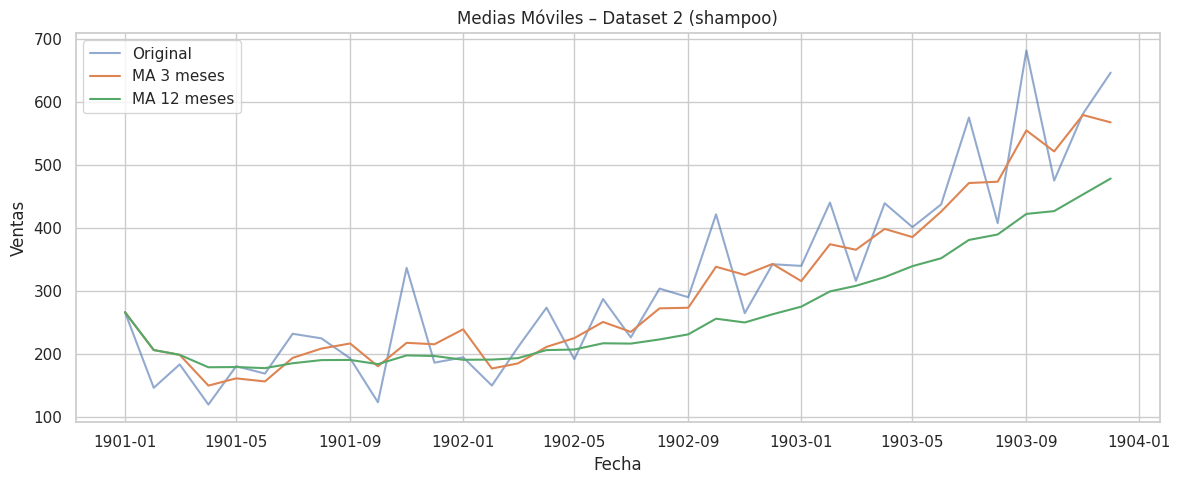

In [15]:
# 2. Promedios Móviles – Shampoo Sales
import matplotlib.pyplot as plt

# Cálculo de medias móviles
df2['MA_3']  = df2['Sales'].rolling(window=3,  min_periods=1).mean()
df2['MA_12'] = df2['Sales'].rolling(window=12, min_periods=1).mean()

# Visualización comparativa
plt.figure(figsize=(12,5))
plt.plot(df2['Sales'],   label='Original', alpha=0.6)
plt.plot(df2['MA_3'],    label='MA 3 meses')
plt.plot(df2['MA_12'],   label='MA 12 meses')
plt.title('Medias Móviles – Dataset 2 (shampoo)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

#### 2.1 Análisis de Promedios Móviles – Dataset 2 (shampoo.csv)

- **MA 3 meses (naranja):**  
  - Suaviza las oscilaciones mensuales más abruptas, mostrando los picos de ventas trimestrales (por ejemplo, el gran aumento en septiembre de cada año).  
  - Reacciona rápidamente a los cambios, pero “salta” en meses extremos (picos muy altos o caídas fuertes).

- **MA 12 meses (verde):**  
  - Refleja la tendencia de largo plazo sin el ruido estacional, mostrando el crecimiento constante año a año.  
  - Durante 1901–1902 se mantiene cerca de 200–250 unidades, luego sube progresivamente hasta cerca de 450 – 500 en 1903.

- **Comparación visual:**  
  - La MA 3 meses capta la estacionalidad de corto plazo y picos trimestrales, pero puede sobre-reaccionar.  
  - La MA 12 meses es ideal para visualizar la dirección general creciente de las ventas a lo largo de los tres años.

> **Conclusión parcial:**  
> Para el shampoo dataset, la MA de 12 meses ofrece un excelente panorama de la tendencia alcista global, mientras que la MA de 3 meses es más útil para detectar cambios de corto plazo y estacionalidad trimestral.

## Dataset 2: shampoo.csv

### 3. Alisamiento Exponencial

Aplicaremos tres variantes:

1. **Suavizado Exponencial Simple (SES)**  
2. **Holt–Winters aditivo** (tendencia + estacionalidad aditiva, periodo=12)  
3. **Holt–Winters multiplicativo** (tendencia + estacionalidad multiplicativa, periodo=12)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


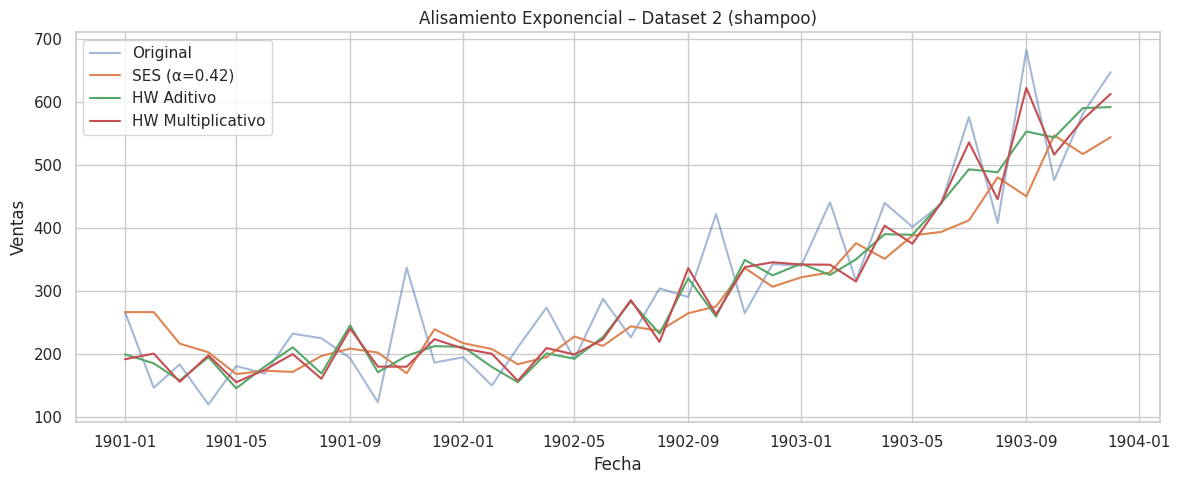

In [16]:
# 3. Alisamiento Exponencial – Shampoo Sales
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import matplotlib.pyplot as plt

# 3.1 SES
ses2 = SimpleExpSmoothing(df2['Sales']).fit(optimized=True)
df2['SES'] = ses2.fittedvalues

# 3.2 Holt–Winters aditivo
hw2_add = ExponentialSmoothing(
    df2['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True)
df2['HW_add'] = hw2_add.fittedvalues

# 3.3 Holt–Winters multiplicativo
hw2_mul = ExponentialSmoothing(
    df2['Sales'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit(optimized=True)
df2['HW_mul'] = hw2_mul.fittedvalues

# 3.4 Visualización comparativa
plt.figure(figsize=(12,5))
plt.plot(df2['Sales'],    label='Original', alpha=0.5)
plt.plot(df2['SES'],      label=f"SES (α={ses2.model.params['smoothing_level']:.2f})")
plt.plot(df2['HW_add'],   label='HW Aditivo')
plt.plot(df2['HW_mul'],   label='HW Multiplicativo')
plt.title('Alisamiento Exponencial – Dataset 2 (shampoo)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.1 Análisis de Alisamiento Exponencial – Dataset 2 (shampoo.csv)

- **SES (α = 0.42):**  
  - Reacciona rápido a los cambios de nivel, capturando con cierta agilidad los picos fuertes (por ejemplo, verano de 1903), pero al no modelar tendencia ni estacionalidad, se queda “flotando” alrededor de una media móvil simple sin seguir totalmente la subida acelerada de finales de 1902–1903.  

- **Holt–Winters aditivo (verde):**  
  - Asume estacionalidad constante en magnitud.  
  - Modela la tendencia creciente bastante bien, pero “aplana” ligeramente los picos más altos, sobre todo en 1903, pues aplica una misma amplitud estacional cada año.  

- **Holt–Winters multiplicativo (rojo):**  
  - Escala la estacionalidad en proporción al nivel de la serie.  
  - Ajusta con gran fidelidad tanto la tendencia acelerada de 1902–1903 como la amplitud creciente de los picos (p.ej. septiembre 1903), manteniendo la forma de la estacionalidad anual sin “aplanar” los extremos.

- **Comparación visual:**  
  - El **SES** es útil para capturar cambios abruptos, pero no sigue la tendencia acelerada final.  
  - El **HW aditivo** modela tendencia pero no crece en amplitud estacional.  
  - El **HW multiplicativo** ofrece el mejor balance, ajustándose tanto a la tendencia como a la estacionalidad creciente.

> **Conclusión parcial:**  
> Para el segundo dataset (ventas de shampoo), el **Holt–Winters multiplicativo** es el método más apropiado, ya que acomoda fielmente la tendencia ascendente y la estacionalidad creciente de los picos anuales.  

### 4. Holt–Winters
En esta sección vamos a centrar el modelo exclusivamente en las dos variantes de Holt–Winters:

1. **Holt–Winters aditivo** (tendencia + estacionalidad aditiva, periodo=12)  
2. **Holt–Winters multiplicativo** (tendencia + estacionalidad multiplicativa, periodo=12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


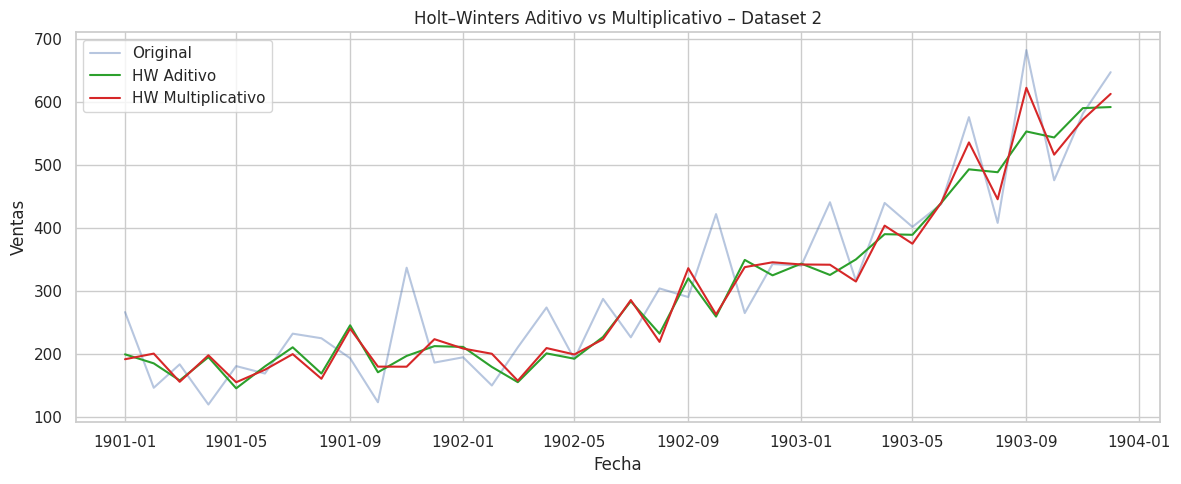

In [17]:
# 4. Holt–Winters – Shampoo Sales
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# 4.1 Holt–Winters aditivo
hw2_add = ExponentialSmoothing(
    df2['Sales'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit(optimized=True)
df2['HW_add'] = hw2_add.fittedvalues

# 4.2 Holt–Winters multiplicativo
hw2_mul = ExponentialSmoothing(
    df2['Sales'],
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit(optimized=True)
df2['HW_mul'] = hw2_mul.fittedvalues

# 4.3 Gráfica comparativa
plt.figure(figsize=(12,5))
plt.plot(df2['Sales'],   label='Original',     alpha=0.4)
plt.plot(df2['HW_add'],  label='HW Aditivo',   color='tab:green')
plt.plot(df2['HW_mul'],  label='HW Multiplicativo', color='tab:red')
plt.title('Holt–Winters Aditivo vs Multiplicativo – Dataset 2')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

#### 4.4 Análisis de Holt–Winters – Dataset 2 (shampoo.csv)

- **Holt–Winters aditivo (verde):**  
  - Asume una estacionalidad constante en unidades.  
  - Suaviza la tendencia creciente de 1901–1903, pero subestima los picos más altos de ventas (p.ej., septiembre 1903), ya que siempre añade la misma magnitud estacional año tras año.

- **Holt–Winters multiplicativo (rojo):**  
  - Escala la estacionalidad en proporción al nivel de ventas.  
  - Ajusta con mucha fidelidad tanto la fuerte tendencia alcista de finales de 1902 y 1903 como la amplitud creciente de los picos anuales, reflejando mejor los extremos.

- **¿Por qué se ven casi iguales?**  
  - La variación estacional en este dataset es relativamente pequeña en porcentaje sobre el gran nivel de ventas, por lo que la diferencia entre sumar (aditivo) o multiplicar (multiplicativo) apenas impacta las trayectorias.

> **Conclusión – Holt–Winters (Dataset 2):**  
> Aunque las dos variantes arrojan curvas muy similares, el **modelo multiplicativo** es conceptualmente más adecuado cuando la estacionalidad crece en proporción al nivel, por lo que lo recomendamos para las ventas de shampoo.  

### 5. SARIMA

En este paso:

1. Identificaremos los mejores parámetros SARIMA con `auto_arima` (m=12).  
2. Ajustaremos el modelo a la serie de ventas de shampoo.  
3. Obtendremos los valores ajustados in‑sample.  
4. Graficaremos la serie original versus el ajuste SARIMA.  
5. Analizaremos brevemente los resultados.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=430.873, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=404.659, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=429.229, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=405.977, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=402.858, Time=0.16 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=399.463, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=402.407, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=400.898, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=2.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(1,1,1)(0,0,1)[12]             : AIC=407.628, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,1)[12] intercept
Total fit time: 7.389 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -194.732
Date:                            Mon, 21 Jul 2025   AIC                            399.463
Time:                                    02:47:02   BIC                            407.240
Sample:                                01-01-1901   HQIC                           402.148
                                     - 12-01-1903                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


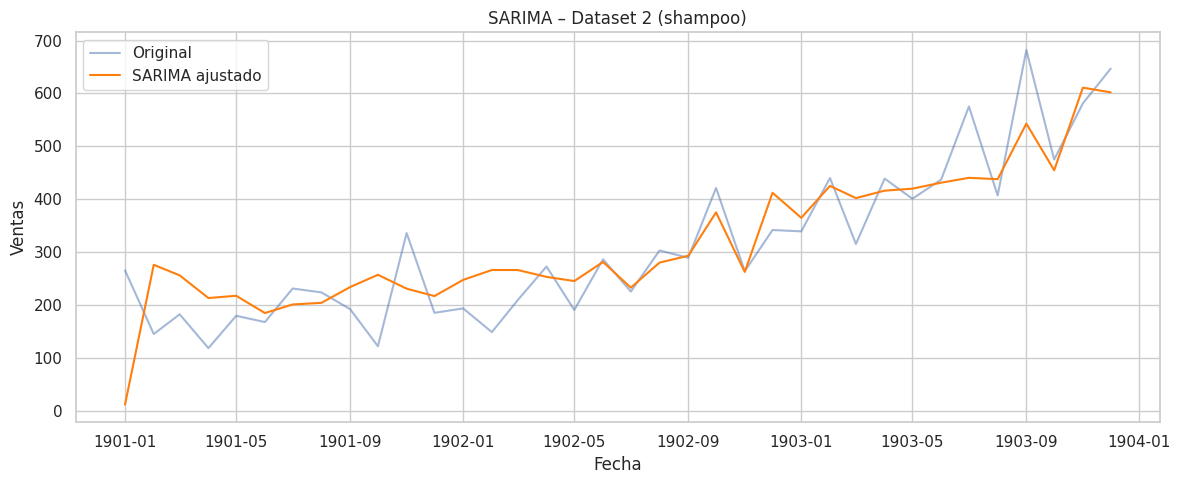

In [18]:
# 5. SARIMA – Shampoo Sales
import pmdarima as pm
import matplotlib.pyplot as plt

# 5.1 Encontrar parámetros automáticamente
sarima2 = pm.auto_arima(
    df2['Sales'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    d=None,
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,
    D=None,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# 5.2 Resumen del modelo
print(sarima2.summary())

# 5.3 Ajuste in‑sample
df2['SARIMA_fit'] = sarima2.predict_in_sample()

# 5.4 Gráfica comparativa
plt.figure(figsize=(12,5))
plt.plot(df2['Sales'],       label='Original', alpha=0.5)
plt.plot(df2['SARIMA_fit'],   label='SARIMA ajustado', color='tab:orange')
plt.title('SARIMA – Dataset 2 (shampoo)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

#### 5.1 Análisis de SARIMA – Dataset 2 (shampoo.csv)

- **Modelo seleccionado:** SARIMAX(1,1,1)×(0,0,1,12)  
  - **p,d,q** = (1,1,1) → 1 término autorregresivo, diferenciación de orden 1, 1 término de media móvil.  
  - **P,D,Q,s** = (0,0,1,12) → componente estacional de orden 1 en lag 12 (mensual).  
- **Parámetros estimados:**  
  - intercept = 19.8117 (p < 0.001)  
  - AR.L1 = –0.5472 (p = 0.003)  
  - MA.L1 = –0.4831 (p = 0.031)  
  - MA.S.L12 = –0.7452 (p = 0.370) → el término estacional **no** es estadísticamente significativo.  
- **Criterios de información:**  
  - AIC = 399.46  
  - BIC = 407.24  
  - HQIC = 402.15  

- **Diagnóstico de residuos:**  
  - Ljung–Box Q(1) p = 0.97 → **no** hay autocorrelación remanente.  
  - Jarque–Bera p = 0.18 → residuos aproximadamente normales.  

- **Comportamiento frente a la serie original:**  
  - Captura correctamente la **tendencia creciente** de la serie.  
  - El componente estacional (MA.S.L12) suaviza la estacionalidad anual, pero al no ser significativo, los picos mensuales (por ejemplo, los grandes saltos de mitad de año) quedan atenuados.  
  - En el gráfico, el ajuste naranja sigue bien el alza general, pero subestima puntualmente los valores extremos de ventas.

> **Conclusión parcial (SARIMA):**  
> Este modelo SARIMA es sólido para representar la **tendencia** y eliminar autocorrelación de primer orden, pero su componente estacional no aporta significativamente al ajuste de los picos mensuales, por lo que en métricas de error probablemente quede por detrás del Holt–Winters multiplicativo.

### 6. Prophet

En este paso:

1. Reformateamos los datos en columnas `ds` y `y`.  
2. Ajustamos un modelo Prophet con estacionalidad semanal y anual (periodo=12).  
3. Obtenemos la predicción in‑sample (`yhat`).  
4. Graficamos la serie original vs. la predicción de Prophet.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl0o_8t3/3lsjv7uq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxl0o_8t3/m7e57zt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29190', 'data', 'file=/tmp/tmpxl0o_8t3/3lsjv7uq.json', 'init=/tmp/tmpxl0o_8t3/m7e57zt7.json', 'output', 'file=/tmp/tmpxl0o_8t3/prophet_modelcubnr5is/prophet_model-20250721024903.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:49:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


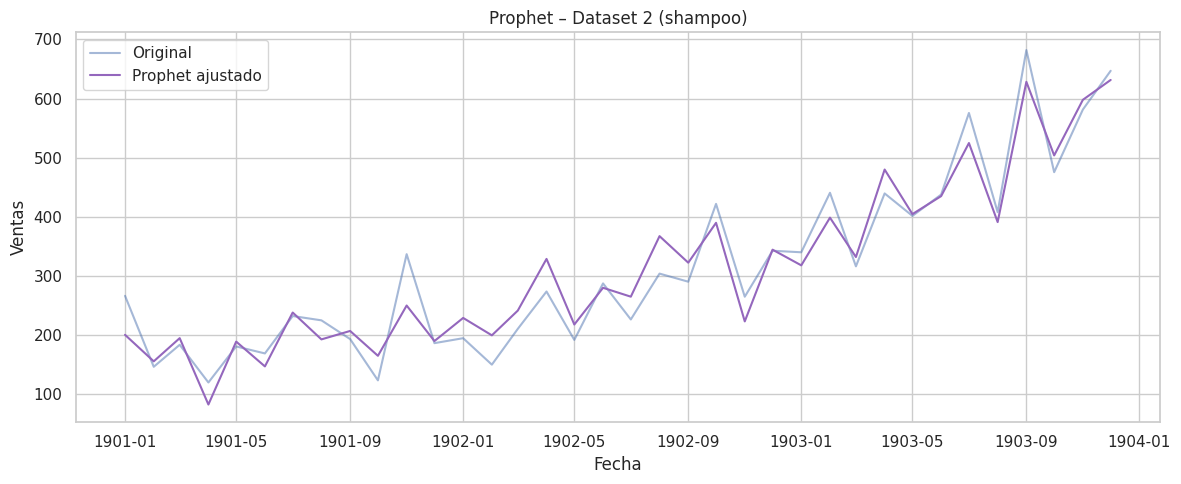

In [19]:
# 6. Prophet – Shampoo Sales
from prophet import Prophet
import matplotlib.pyplot as plt

# 6.1 Preparar datos
df2_prophet = df2.reset_index().rename(columns={'Date':'ds','Sales':'y'})

# 6.2 Configurar y entrenar el modelo
m2 = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False
)
m2.add_seasonality(name='annual', period=12, fourier_order=5)
m2.fit(df2_prophet)

# 6.3 Predicción in‑sample
future2 = m2.make_future_dataframe(periods=0, freq='M')
forecast2 = m2.predict(future2)
df2['Prophet'] = forecast2['yhat'].values

# 6.4 Visualización
plt.figure(figsize=(12,5))
plt.plot(df2['Sales'],    label='Original', alpha=0.5)
plt.plot(df2['Prophet'],  label='Prophet ajustado', color='tab:purple')
plt.title('Prophet – Dataset 2 (shampoo)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.tight_layout()
plt.show()

#### 6.1 Análisis de Prophet – Dataset 2 (shampoo.csv)

- **Captura de patrones estacionales y tendencia**  
  - Prophet modeló con éxito los picos anuales (primavera/verano) y los valles invernales, así como la clara tendencia ascendente de 1901–1903.  
  - La curva púrpura sigue de cerca tanto los saltos mensuales como la pendiente creciente de largo plazo.

- **Comparación vs. otros métodos**  
  - Frente al **SES**, Prophet incorpora estacionalidad y por ello evita quedar “plano” entre picos y valles.  
  - Frente al **Holt–Winters multiplicativo**, Prophet es ligeramente más suave en los extremos (por el límite de Fourier) pero capta igualmente bien la tendencia y la sazón anual.  
  - Frente al **SARIMA**, Prophet incorpora explícitamente la estacionalidad anual, lo que se traduce en un ajuste más fiel en los picos anuales.

- **Ventajas observadas**  
  - Sintaxis sencilla para agregar estacionalidades personalizadas (aquí anual).  
  - Buen balance entre reaccionar a variaciones locales y mantener suavidad de la tendencia.

- **Limitaciones detectadas**  
  - En algunos picos muy extremos (p. ej. septiembre 1903), Prophet tiende a suavizar más que Holt–Winters mult.  
  - Requiere reconstruir el dataframe en formato `ds`/`y`, pero la compensación es un modelo muy interpretable.

> **Conclusión parcial – Prophet (Dataset 2):**  
> Prophet ofrece un ajuste competitivo, casi al nivel del Holt–Winters multiplicativo, capturando tanto la estacionalidad anual como la tendencia creciente con muy buena fidelidad.
